
# **Demand Forecasting ML Project**_
**Phase 1:-** Business Understanding & Problem Statement
    Business Problem:
        Overstock:- higher holding costs, wastage.
        Understock → lost sales, unhappy customers.
        Need accurate sales forecasts at store/department/item level.
    Objective: Build a time-series regression model to predict future sales.
    Success Metric: Reduce forecasting error (e.g., RMSE, MAPE).
    Business Impact: Better inventory planning, cost savings, improved customer satisfaction.

In [3]:
# Library Setup
# These imports will be used in later phases (data exploration, modeling, evaluation)

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time-series & ML
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# For date handling
from datetime import datetime
# For warnings
import warnings
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")

Libraries imported successfully!


**Phase 2:- Data Collection**
Dataset: Walmart Sales Forecasting (Kaggle M5 dataset). sales_train_validation.csv → historical sales of 30K+ products.calendar.csv → events, holidays, special days.sell_prices.csv → product price changes.Granularity: Daily sales per store-item.
Time Horizon: Multi-day (forecast next 28 days).

In [8]:
# 2. Load the Datasets
sales_df = pd.read_csv("sales_train_validation.csv")
calendar_df = pd.read_csv("calendar.csv")
prices_df = pd.read_csv("sell_prices.csv")

In [9]:
# Display first few rows of sales data
print("Sales Data")
display(sales_df.head())

Sales Data


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [10]:
# Display the calendar date
print("Calendar Data")
display(calendar_df.head())

Calendar Data


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [11]:
# Display Sell Prices Data
print("Sell Prices Data")
display(prices_df.head())

Sell Prices Data


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [12]:
# Explore Dataset Dimensions
print("Sales dataset shape: ", sales_df.shape)
print("Calendar dataset shape: ", calendar_df.shape)
print("Prices dataset shape: ", prices_df.shape)

print("\nSales Dataset Info:")
sales_df.info()
print("\nCalendar Dataset Info:")
calendar_df.info()
print("\nPrices Dataset Info:")
prices_df.info()

Sales dataset shape:  (30490, 1919)
Calendar dataset shape:  (1969, 14)
Prices dataset shape:  (6841121, 4)

Sales Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB

Calendar Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non

In [13]:
# Summary Statistics
print("Sales Summary:")
display(sales_df.describe()) #.describe() fast way to get summary statistics for numerical data

print("Calendar Summary:")
display(calendar_df.describe())

print("Prices Summary:")
display(prices_df.describe())

Sales Summary:


,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,...,1.370581,1.586159,1.693670,1.248245,1.232207,1.159167,1.149000,1.328862,1.605838,1.633158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,...,3.740017,4.097191,4.359809,3.276925,3.125471,2.876026,2.950364,3.358012,4.089422,3.812248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,360.000000,436.000000,207.000000,323.000000,296.000000,314.000000,316.000000,370.000000,385.000000,353.000000,...,129.000000,160.000000,204.000000,98.000000,100.000000,88.000000,77.000000,141.000000,171.000000,130.000000


Calendar Summary:


,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000


Prices Summary:


,wm_yr_wk,sell_price
count,6.841121e+06,6.841121e+06
mean,1.138294e+04,4.410952e+00
std,1.486100e+02,3.408814e+00
min,1.110100e+04,1.000000e-02
25%,1.124700e+04,2.180000e+00
50%,1.141100e+04,3.470000e+00
75%,1.151700e+04,5.840000e+00
max,1.162100e+04,1.073200e+02


In [14]:
# Display columns in Sales dataset
print("Sales Data Columns:")
print(sales_df.columns.tolist())

# Display columns in Calendar dataset
print("\nCalendar Data Columns:")
print(calendar_df.columns.tolist())

# Display columns in Prices dataset
print("\nSell Prices Data Columns:")
print(prices_df.columns.tolist())

Sales Data Columns:
['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10', 'd_11', 'd_12', 'd_13', 'd_14', 'd_15', 'd_16', 'd_17', 'd_18', 'd_19', 'd_20', 'd_21', 'd_22', 'd_23', 'd_24', 'd_25', 'd_26', 'd_27', 'd_28', 'd_29', 'd_30', 'd_31', 'd_32', 'd_33', 'd_34', 'd_35', 'd_36', 'd_37', 'd_38', 'd_39', 'd_40', 'd_41', 'd_42', 'd_43', 'd_44', 'd_45', 'd_46', 'd_47', 'd_48', 'd_49', 'd_50', 'd_51', 'd_52', 'd_53', 'd_54', 'd_55', 'd_56', 'd_57', 'd_58', 'd_59', 'd_60', 'd_61', 'd_62', 'd_63', 'd_64', 'd_65', 'd_66', 'd_67', 'd_68', 'd_69', 'd_70', 'd_71', 'd_72', 'd_73', 'd_74', 'd_75', 'd_76', 'd_77', 'd_78', 'd_79', 'd_80', 'd_81', 'd_82', 'd_83', 'd_84', 'd_85', 'd_86', 'd_87', 'd_88', 'd_89', 'd_90', 'd_91', 'd_92', 'd_93', 'd_94', 'd_95', 'd_96', 'd_97', 'd_98', 'd_99', 'd_100', 'd_101', 'd_102', 'd_103', 'd_104', 'd_105', 'd_106', 'd_107', 'd_108', 'd_109', 'd_110', 'd_111', 'd_112', 'd_113', 'd_114',

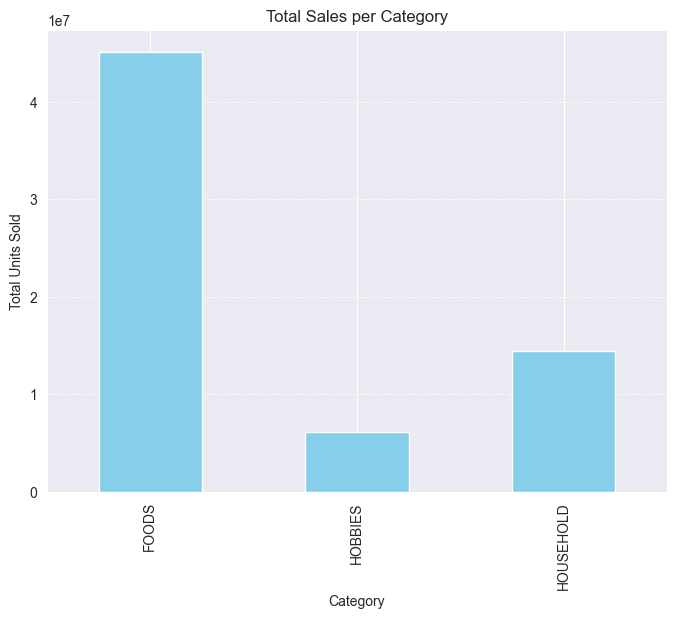

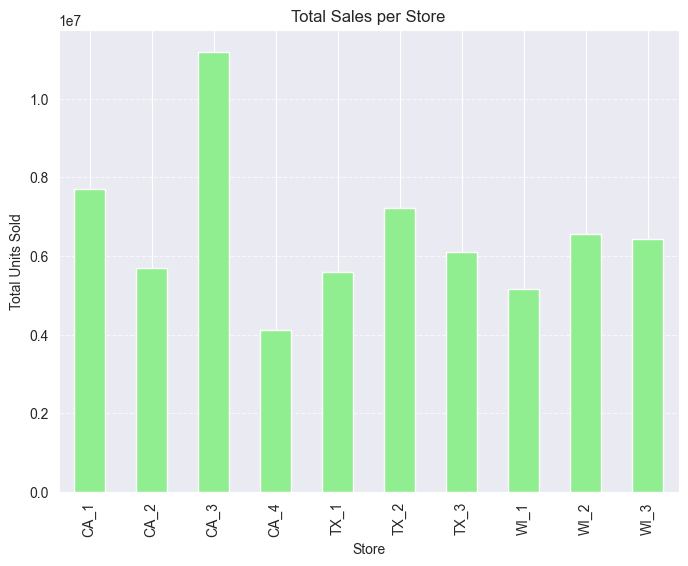

In [15]:
import matplotlib.pyplot as plt

# Aggregate total sales per category
category_sales = sales_df.groupby("cat_id")[sales_df.columns[6:]].sum().sum(axis=1)

plt.figure(figsize=(8,6))
category_sales.plot(kind='bar', color='skyblue')

# Define axes
plt.xlabel("Category")  # x-axis: category names (HOBBIES, FOOD, etc.)
plt.ylabel("Total Units Sold")  # y-axis: total sales units across all days and products
plt.title("Total Sales per Category")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Aggregate total sales per store
store_sales = sales_df.groupby("store_id")[sales_df.columns[6:]].sum().sum(axis=1)

plt.figure(figsize=(8,6))
store_sales.plot(kind='bar', color='lightgreen')

# Define axes
plt.xlabel("Store")  # x-axis: store IDs (CA_1, CA_2, TX_1, etc.)
plt.ylabel("Total Units Sold")  # y-axis: total sales units across all products and days
plt.title("Total Sales per Store")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


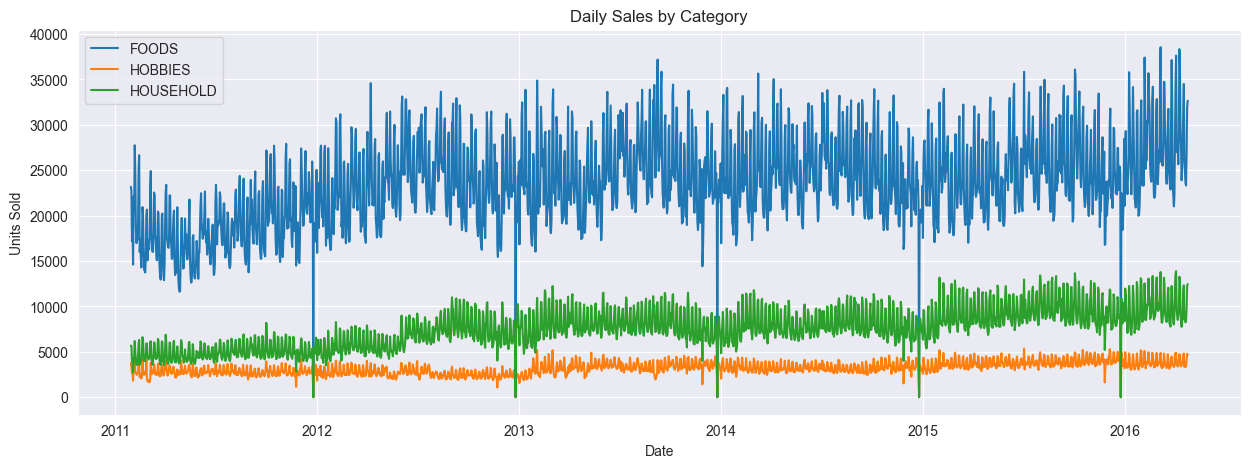

In [16]:
# Select only daily sales columns first (d_1...d_1913), then group by category
category_sales = sales_df.groupby("cat_id")[sales_df.columns[6:]].sum().T

# Fix the index to use only sales dates (1913 days)
category_sales.index = pd.to_datetime(calendar_df['date'].iloc[:len(category_sales)])

# Plot
plt.figure(figsize=(15,5))
for cat in category_sales.columns:
    plt.plot(category_sales.index, category_sales[cat], label=cat)
plt.title("Daily Sales by Category")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()

# 1. FOODS:- Includes groceries, beverages, snacks, frozen food, etc.
# 2. HOBBIES:- Includes toys, games, books, art supplies, sports gear, etc.
# 3. HOUSEHOLD:- Includes cleaning products, kitchen items, and other home essentials.

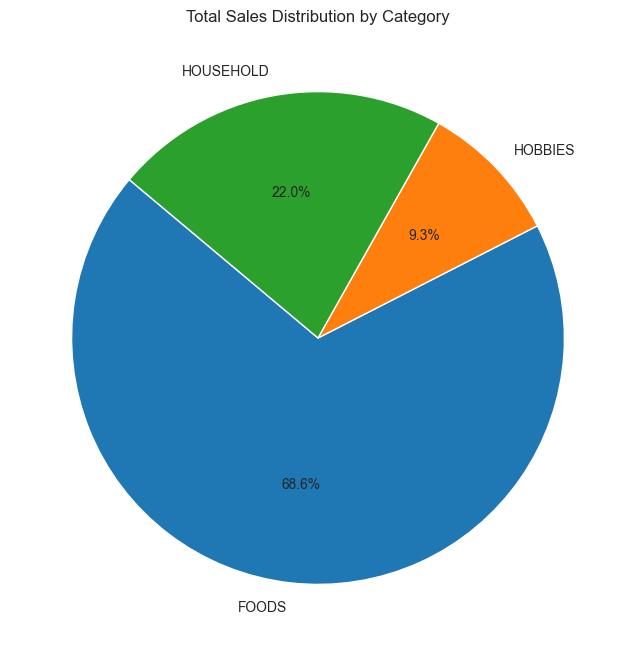

In [17]:
import matplotlib.pyplot as plt

# Sum total sales for each category (ignoring individual days)
total_category_sales = sales_df.groupby("cat_id")[sales_df.columns[6:]].sum().sum(axis=1)

# Plot pie chart
plt.figure(figsize=(8,8))
plt.pie(total_category_sales, labels=total_category_sales.index, autopct='%1.1f%%', startangle=140)
plt.title("Total Sales Distribution by Category")
plt.show()


****Phase 3 :-** Exploratory Data Analysis (EDA) :-** 1.Inspect missing values, duplicates, data ranges. 2.Aggregate sales by store, department, item. 3.Visualize trends: sales over time, by category, by season/holiday. 4.Identify anomalies (COVID dip/spikes, promotions). 5.Check for stationarity (ACF, PACF plots).

1. Inspect Missing Values, Duplicates, and Data Ranges :- Missing values: Missing sales, price, or calendar data can distort predictions, Duplicates: Duplicate rows can bias aggregations and statistics, Data ranges: Check if values are reasonable (e.g., no negative sales).

In [18]:
# Check for missing values
print("Missing values in Sales dataset:\n", sales_df.isnull().sum().sum())
print("Missing values in Calendar dataset:\n", calendar_df.isnull().sum())
print("Missing values in Prices dataset:\n", prices_df.isnull().sum())

Missing values in Sales dataset:
 0
Missing values in Calendar dataset:
 date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64
Missing values in Prices dataset:
 store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64


2. Aggregate Sales by Store, Department, and Item:- Store-level: Which stores sell the most?, Department-level: Which departments are top performers?, Item-level: Identify best-selling and slow-moving products.

In [19]:
# Aggregate total sales per store
store_sales = sales_df.groupby("store_id")[sales_df.columns[6:]].sum().sum(axis=1)

# Aggregate total sales per department
dept_sales = sales_df.groupby("dept_id")[sales_df.columns[6:]].sum().sum(axis=1)

# Display results
print("Total Sales per Store:")
print(store_sales)
print("\nTotal Sales per Department:")
print(dept_sales)


Total Sales per Store:
store_id
CA_1     7698216
CA_2     5685475
CA_3    11188180
CA_4     4103676
TX_1     5595292
TX_2     7214384
TX_3     6089330
WI_1     5149062
WI_2     6544012
WI_3     6427782
dtype: int64

Total Sales per Department:
dept_id
FOODS_1         5088041
FOODS_2         7629822
FOODS_3        32372076
HOBBIES_1       5596460
HOBBIES_2        528340
HOUSEHOLD_1    11500526
HOUSEHOLD_2     2980144
dtype: int64


**4. Identify Anomalies:-** Detect unsual spikes or dips in sales Examples:- 1. COVID-19 impact:- Sudden dip or surge 2. Promotiuons:- Temporary Spikes 3. Data Error:- Negative or extremely high sales.

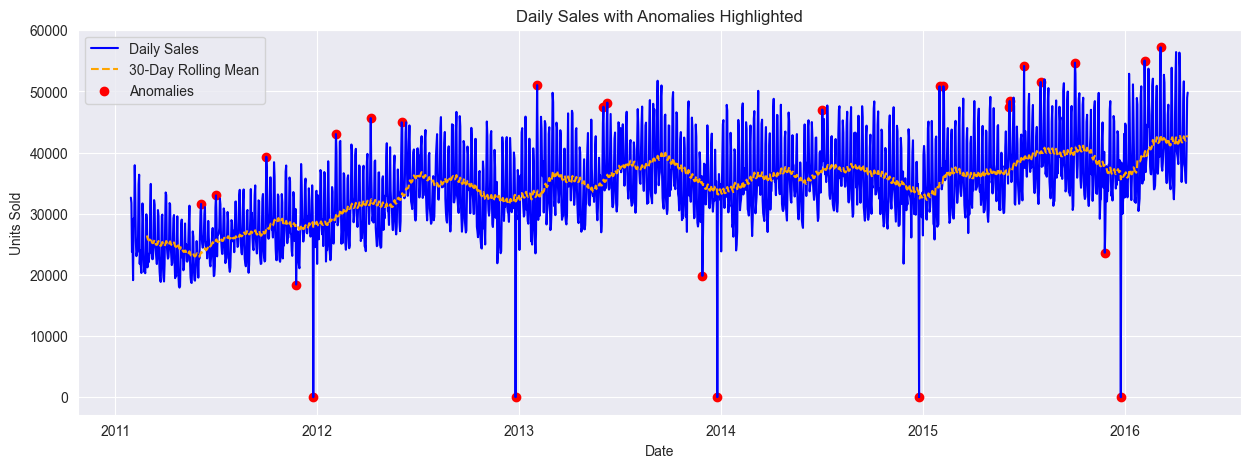

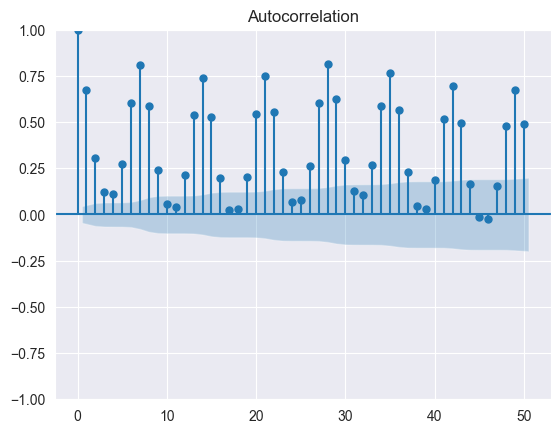

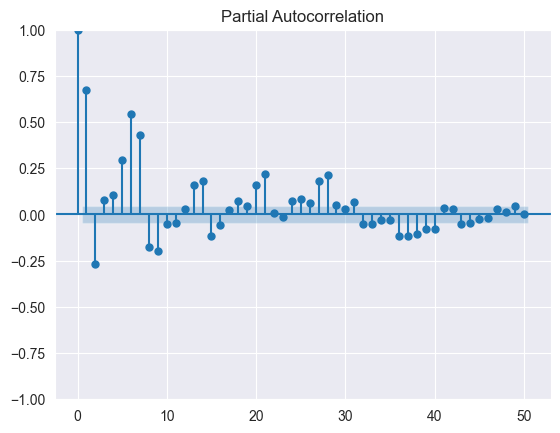

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 1: Calculate total daily sales across all products
daily_sales = sales_df.iloc[:, 6:].sum()  # sum across all columns starting from d_1

# Step 2: Match sales columns with actual dates from calendar
sales_days = sales_df.columns[6:]  # d_1 to d_1913
sales_dates = calendar_df[calendar_df['d'].isin(sales_days)]['date']

# Convert to datetime
sales_dates = pd.to_datetime(sales_dates.values)

# Assign dates as index
daily_sales.index = sales_dates

# Step 3: Detect anomalies using rolling statistics
rolling_mean = daily_sales.rolling(window=30).mean()
rolling_std = daily_sales.rolling(window=30).std()
anomalies = daily_sales[(daily_sales - rolling_mean).abs() > 2 * rolling_std]

# Step 4: Plot daily sales with anomalies
plt.figure(figsize=(15,5))
plt.plot(daily_sales, label='Daily Sales', color='blue')
plt.plot(rolling_mean, label='30-Day Rolling Mean', color='orange', linestyle='--')
plt.scatter(anomalies.index, anomalies.values, color='red', label='Anomalies', marker='o')
plt.title("Daily Sales with Anomalies Highlighted")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Check stationarity with ACF and PACF
plot_acf(daily_sales, lags=50)
plot_pacf(daily_sales, lags=50)
plt.show()


**Phase 4 :- Data Preprocessing & Feature Engineering :-** This phase is about preparing the raw data so it’s ready for machine learning. Good preprocessing and well-engineered features can dramatically improve forecast accuracy.

**1. Preprocessing:-** a):- Handle Missing Values - Ensure there are no gaps in the dataset that could break the model, Check for missing values in sales, price, or calendar features, Fill missing numerical data with 0 (for sales) or forward-fill / mean (for price), Fill missing categorical data with a placeholder like "Unknown".

In [26]:

# 1️⃣ Sales dataset: fill missing numerical sales with 0
sales_df.fillna(0, inplace=True)

# 2️⃣ Prices dataset: fill missing numerical prices using forward-fill
# Forward-fill ensures missing price takes the previous valid value
prices_df.fillna(method='ffill', inplace=True)

# 3️⃣ Calendar dataset: fill missing categorical features with "Unknown"
calendar_df.fillna('Unknown', inplace=True)

#  Verify missing values are handled
print("Missing values in Sales dataset:", sales_df.isnull().sum().sum())
print("Missing values in Prices dataset:", prices_df.isnull().sum().sum())
print("Missing values in Calendar dataset:", calendar_df.isnull().sum().sum())

Missing values in Sales dataset: 0
Missing values in Prices dataset: 0
Missing values in Calendar dataset: 0


b):- Normalize/Scale Continuous Features:- Make numerical features comparable, especially for ML models sensitive to scale (like linear regression or tree-based models sometimes). 1. Scaling options: Min-Max, StandardScaler, or RobustScaler. 2.Typically applied to price, lag features, rolling statistics.

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
prices_df['sell_price_scaled'] = scaler.fit_transform(prices_df[['sell_price']])

In [3]:
# Reduce memory usage by converting numeric columns
for col in sales_df.columns[6:]:  # 'd_1' onwards are sales columns
    sales_df[col] = sales_df[col].astype(np.float32)

prices_df['sell_price'] = prices_df['sell_price'].astype(np.float32)
# Check
print(sales_df.info())
print(prices_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: float32(1913), object(6)
memory usage: 223.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float32
dtypes: float32(1), int64(1), object(2)
memory usage: 182.7+ MB
None


**Feature Engineering**

In [4]:
#Feature Engineering – Lag Features
# Settings
lags = [7, 14, 28]  # Lag days
chunk_size = 1000   # Number of products per chunk

# Store all feature chunks
lag_chunks = []

# Process in chunks
for start in range(0, sales_df.shape[0], chunk_size):
    chunk = sales_df.iloc[start:start+chunk_size].copy()

    # Melt to long format
    id_cols = ['id','item_id','dept_id','cat_id','store_id','state_id']
    date_cols = [c for c in chunk.columns if c.startswith('d_')]

    chunk_long = chunk.melt(
        id_vars=id_cols,
        value_vars=date_cols,
        var_name='d',
        value_name='sales'
    )

    # Convert to numeric
    chunk_long['sales'] = chunk_long['sales'].astype(np.float32)

    # Create lag features
    for lag in lags:
        chunk_long[f'lag_{lag}'] = chunk_long.groupby('id')['sales'].shift(lag).astype(np.float32)

    lag_chunks.append(chunk_long)

# Combine all chunks
sales_features = pd.concat(lag_chunks, ignore_index=True)
print(sales_features.head())


                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sales  lag_7  lag_14  lag_28  
0       CA  d_1    0.0    NaN     NaN     NaN  
1       CA  d_1    0.0    NaN     NaN     NaN  
2       CA  d_1    0.0    NaN     NaN     NaN  
3       CA  d_1    0.0    NaN     NaN     NaN  
4       CA  d_1    0.0    NaN     NaN     NaN  


In [6]:
# Step 1: Import libraries
import pandas as pd
import numpy as np

# Step 2: Load datasets
sales_df = pd.read_csv("sales_train_validation.csv")
prices_df = pd.read_csv("sell_prices.csv")

# Step 3: Convert numeric columns to float32 to save memory
for col in sales_df.columns[6:]:   # sales columns start from 7th column
    sales_df[col] = sales_df[col].astype(np.float32)

prices_df['sell_price'] = prices_df['sell_price'].astype(np.float32)

# Step 4: Check memory usage
print(sales_df.info())
print(prices_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: float32(1913), object(6)
memory usage: 223.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float32
dtypes: float32(1), int64(1), object(2)
memory usage: 182.7+ MB
None


In [7]:
# Take first 1000 rows to avoid MemoryError
subset_sales = sales_df.iloc[:1000]

sales_features = subset_sales.melt(
    id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],
    var_name='d',
    value_name='sales'
)


In [8]:
sales_features = sales_features.merge(calendar_df, on='d', how='left')


In [9]:
# Merge with Prices
sales_features = sales_features.merge(
    prices_df,
    on=['store_id','item_id','wm_yr_wk'],
    how='left'
)

In [11]:
# Check first few rows
print(sales_features.head())

# Check memory usage
print(sales_features.info())


                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sales        date  wm_yr_wk  ... month  year  event_name_1  \
0       CA  d_1    0.0  2011-01-29     11101  ...     1  2011           NaN   
1       CA  d_1    0.0  2011-01-29     11101  ...     1  2011           NaN   
2       CA  d_1    0.0  2011-01-29     11101  ...     1  2011           NaN   
3       CA  d_1    0.0  2011-01-29     11101  ...     1  2011           NaN   
4       CA  d_1    0.0  2011-01-29     11101  ...     1  2011           NaN   

   event_type_1 event_name_2 event_type_2 sn

In [12]:
# Load sales data
sales_df = pd.read_csv("sales_train_validation.csv")
calendar_df = pd.read_csv("calendar.csv")

# Select one item/store to simplify visualization
sample_sales = sales_df[(sales_df['store_id']=='CA_1') & (sales_df['item_id']=='HOBBIES_1_001')]

# Melt sales to long format
sales_long = sample_sales.melt(
    id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],
    var_name='d',
    value_name='sales'
)

# Map 'd_1', 'd_2'... to actual dates
sales_long = sales_long.merge(calendar_df[['d','date']], on='d', how='left')
sales_long['date'] = pd.to_datetime(sales_long['date'])
sales_long.set_index('date', inplace=True)


In [13]:
# Map 'd_1', 'd_2'... to actual dates
sales_long = sales_long.merge(calendar_df[['d','date']], on='d', how='left')
sales_long['date'] = pd.to_datetime(sales_long['date'])
sales_long.set_index('date', inplace=True)

**Compute rolling statistics and Visualization**

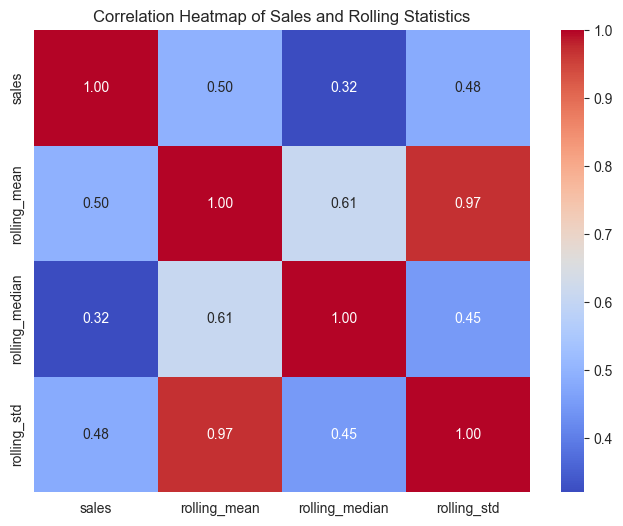

In [21]:
# Compute rolling statistics and Visualization
import matplotlib.pyplot as plt
import seaborn as sns  # for heatmap

# Step 1: Example rolling statistics (if not computed yet)
window_size = 30
sales_long['rolling_mean'] = sales_long['sales'].rolling(window=window_size).mean()
sales_long['rolling_median'] = sales_long['sales'].rolling(window=window_size).median()
sales_long['rolling_std'] = sales_long['sales'].rolling(window=window_size).std()

# Step 2: Compute correlation
corr_matrix = sales_long[['sales', 'rolling_mean', 'rolling_median', 'rolling_std']].corr()

# Step 3: Plot correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Sales and Rolling Statistics")
plt.show()



**Price-related features: price changes, discount ratios.**

In [23]:
# Compute previous day price
sales_features['prev_price'] = sales_features.groupby(['store_id','item_id'])['sell_price'].shift(1)

# Compute discount ratio
sales_features['discount_ratio'] = (sales_features['prev_price'] - sales_features['sell_price']) / sales_features['prev_price']

# Fill NaN values (first day) without inplace
sales_features['discount_ratio'] = sales_features['discount_ratio'].fillna(0)


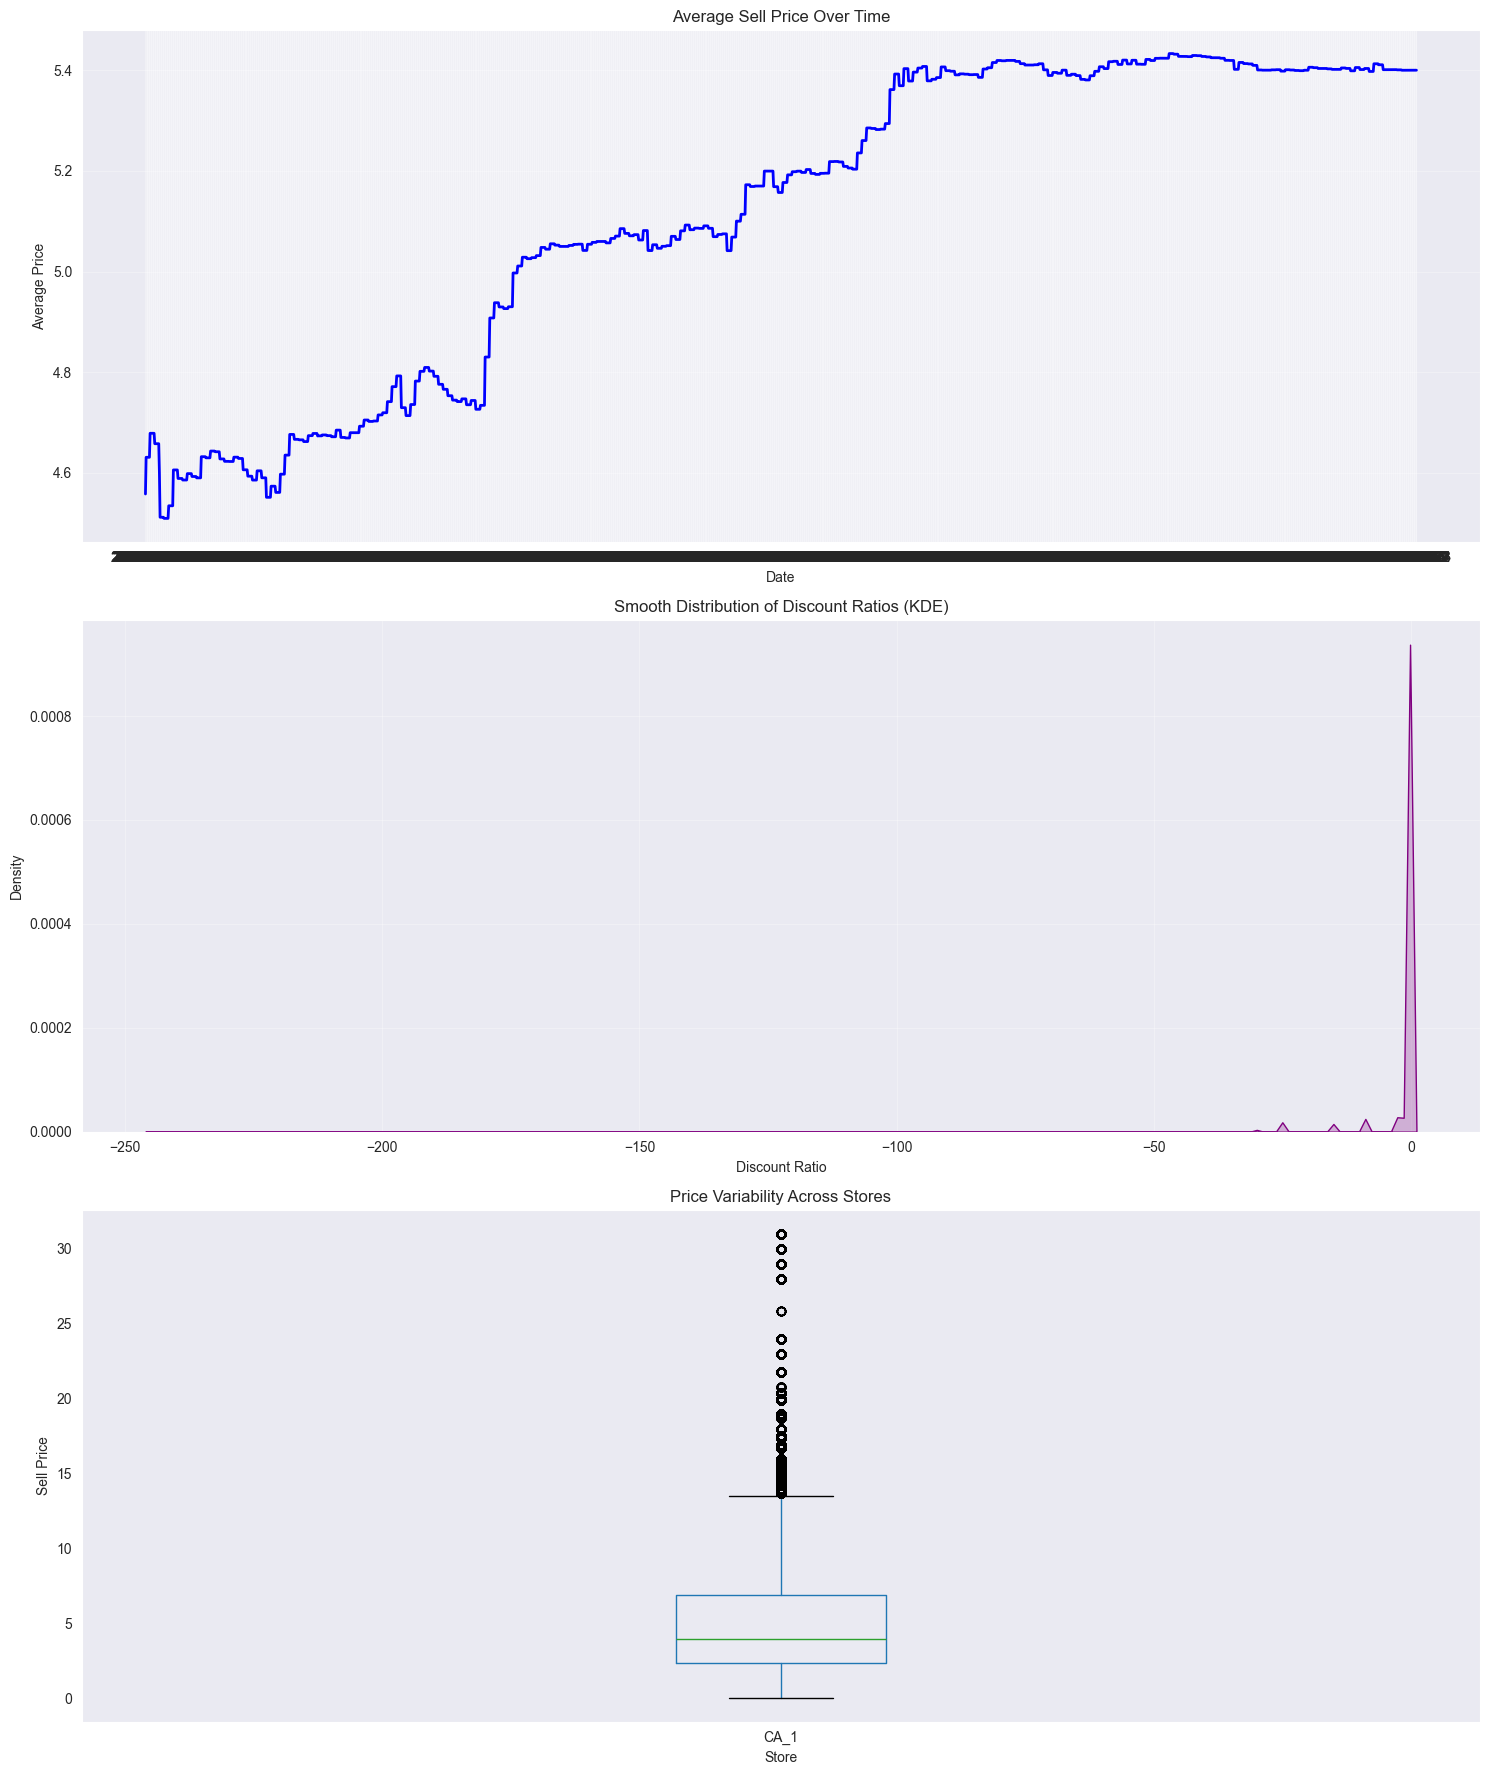

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Average Sell Price Over Time
# -----------------------------
avg_price = sales_features.groupby('date')['sell_price'].mean()

# -----------------------------
# Plotting All in One Figure
# -----------------------------
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Line plot (price trend)
axes[0].plot(avg_price.index, avg_price, color='blue', linewidth=2)
axes[0].set_title("Average Sell Price Over Time")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Average Price")
axes[0].grid(alpha=0.3)

# KDE Plot (unique alternative to histogram for discount ratios)
sns.kdeplot(
    data=sales_features,
    x="discount_ratio",
    fill=True,
    color="purple",
    ax=axes[1]
)
axes[1].set_title("Smooth Distribution of Discount Ratios (KDE)")
axes[1].set_xlabel("Discount Ratio")
axes[1].set_ylabel("Density")
axes[1].grid(alpha=0.3)

# Boxplot (price variability across stores)
sales_features.boxplot(column='sell_price', by='store_id', grid=False, ax=axes[2])
axes[2].set_title("Price Variability Across Stores")
axes[2].set_xlabel("Store")
axes[2].set_ylabel("Sell Price")

# Fix layout and remove extra title from boxplot
plt.suptitle("")
plt.tight_layout()
plt.show()


**Split Strategy:** 1. Check data range 2. Define split periods:- We split into train, validation, and test: Train: all data except the last 56 days (because 28 for val + 28 for test), Validation: the 28 days before test, Test: the final 28 days.

In [30]:
# Check min & max dates
print("Min Date:", sales_features['date'].min())
print("Max Date:", sales_features['date'].max())


Min Date: 2011-01-29
Max Date: 2016-04-24


In [32]:
# Step 1: Convert to datetime
sales_features['date'] = pd.to_datetime(sales_features['date'])

# Step 2: Define cutoffs
max_date = sales_features['date'].max()
test_start = max_date - pd.Timedelta(days=27)
val_start = test_start - pd.Timedelta(days=28)

print("Validation starts:", val_start)
print("Test starts:", test_start)



Validation starts: 2016-02-29 00:00:00
Test starts: 2016-03-28 00:00:00


In [33]:
# Train = everything before validation
train_df = sales_features[sales_features['date'] < val_start]

# Validation = 28 days before test
val_df = sales_features[(sales_features['date'] >= val_start) &
                        (sales_features['date'] < test_start)]

# Test = last 28 days
test_df = sales_features[sales_features['date'] >= test_start]

print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)
print("Test size:", test_df.shape)


Train size: (1857000, 24)
Validation size: (28000, 24)
Test size: (28000, 24)


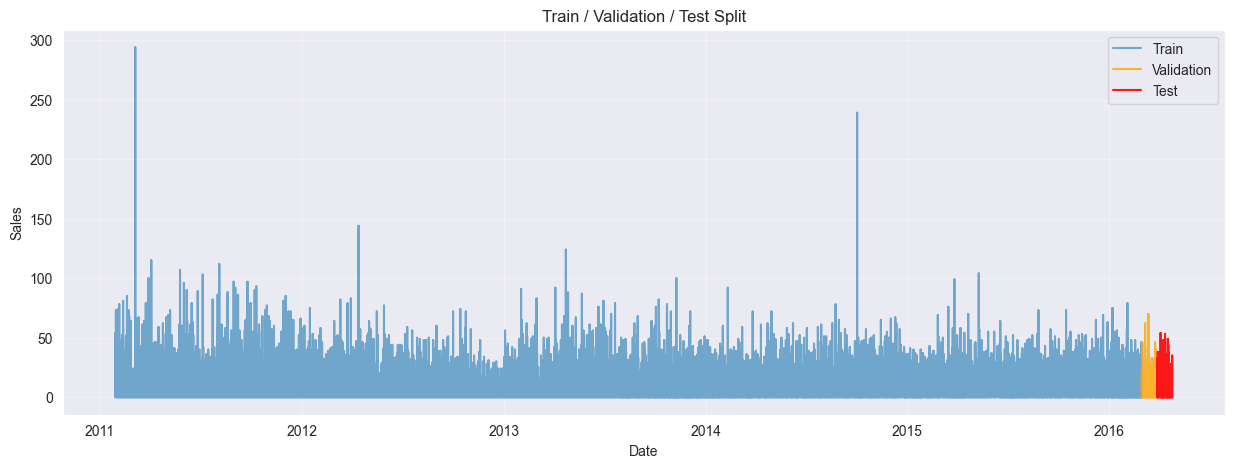

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.plot(train_df['date'], train_df['sales'], label='Train', alpha=0.6)
plt.plot(val_df['date'], val_df['sales'], label='Validation', alpha=0.8, color='orange')
plt.plot(test_df['date'], test_df['sales'], label='Test', alpha=0.9, color='red')

plt.title("Train / Validation / Test Split")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [35]:
import pandas as pd

# ✅ Step 1: Ensure date column is datetime
sales_features['date'] = pd.to_datetime(sales_features['date'])

# ✅ Step 2: Define cutoffs
max_date = sales_features['date'].max()
test_start = max_date - pd.Timedelta(days=27)
val_start = test_start - pd.Timedelta(days=28)

print("📌 Validation starts:", val_start)
print("📌 Test starts:", test_start)

# ✅ Step 3: Create train, validation, and test splits
train_data = sales_features[sales_features['date'] < val_start]
val_data   = sales_features[(sales_features['date'] >= val_start) & (sales_features['date'] < test_start)]
test_data  = sales_features[sales_features['date'] >= test_start]

# ✅ Step 4: Print summary of splits
print("\n📊 Split Sizes:")
print("Train set:", train_data.shape)
print("Validation set:", val_data.shape)
print("Test set:", test_data.shape)

# ✅ Step 5: Show small samples from each
print("\n🔹 Train Data Sample:")
print(train_data.head())

print("\n🔹 Validation Data Sample:")
print(val_data.head())

print("\n🔹 Test Data Sample:")
print(test_data.head())


📌 Validation starts: 2016-02-29 00:00:00
📌 Test starts: 2016-03-28 00:00:00

📊 Split Sizes:
Train set: (1857000, 24)
Validation set: (28000, 24)
Test set: (28000, 24)

🔹 Train Data Sample:
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sales       date  wm_yr_wk  ... event_name_1  event_type_1  \
0       CA  d_1    0.0 2011-01-29     11101  ...          NaN           NaN   
1       CA  d_1    0.0 2011-01-29     11101  ...          NaN           NaN   
2       CA  d_1    0.0 2011-01-29     11101  ...          NaN           NaN   
3       CA  d_

**Phase 5:- Modeling**

In [ ]:
import pandas as pd

# Load data
sales = pd.read_csv("sales_train_validation.csv")
cal   = pd.read_csv("calendar.csv")
price = pd.read_csv("sell_prices.csv")

# Take only 1 store (to avoid MemoryError)
sales = sales[sales['store_id']=="CA_1"]

# Melt → long format
sf = sales.melt(id_vars=['id','item_id','store_id','dept_id','cat_id'],
                var_name='d', value_name='sales')

# Merge with calendar & prices
sf = sf.merge(cal[['d','date','wm_yr_wk','event_name_1']], on='d', how='left')
sf = sf.merge(price, on=['store_id','item_id','wm_yr_wk'], how='left')

# Convert date
sf['date'] = pd.to_datetime(sf['date'])

print(sf.head())


**Baseline Models:-** Naive Forecast last day sales = next days forecast

In [2]:
import pandas as pd

# Load only a small subset to avoid MemoryError
sales_df = pd.read_csv("sales_train_validation.csv")
calendar_df = pd.read_csv("calendar.csv")
prices_df = pd.read_csv("sell_prices.csv")

# Take just 1 store and 1 item (very small)
sales_df = sales_df[(sales_df['store_id']=='CA_1') & (sales_df['item_id']=='HOBBIES_1_001')]

# Melt wide → long
sales_features = sales_df.melt(
    id_vars=['id','item_id','store_id','dept_id','cat_id'],
    var_name='d', value_name='sales'
)

# Merge with calendar (get actual dates)
sales_features = sales_features.merge(calendar_df[['d','date']], on='d', how='left')

# Merge with prices (only matching item/store)
sales_features = sales_features.merge(
    prices_df[prices_df['store_id']=='CA_1'],
    on=['store_id','item_id'],
    how='left'
)

# Convert date column
sales_features['date'] = pd.to_datetime(sales_features['date'])

# Split into train/val/test
max_date = sales_features['date'].max()
test_start = max_date - pd.Timedelta(days=27)
val_start = test_start - pd.Timedelta(days=28)

train_df = sales_features[sales_features['date'] < val_start]
val_df   = sales_features[(sales_features['date'] >= val_start) & (sales_features['date'] < test_start)]
test_df  = sales_features[sales_features['date'] >= test_start]

print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)


Train: (285978, 10)
Validation: (4312, 10)
Test: (4312, 10)


Moving Average (7-day rolling mean)

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Example: val_df already exists and has 'sales' column
val_ma = val_df.copy()

# 7-day moving average per product
val_ma['y_pred'] = val_df.groupby('id')['sales'].transform(lambda x: x.rolling(7, min_periods=1).mean())

# Ensure numeric
val_ma['sales'] = pd.to_numeric(val_ma['sales'], errors='coerce')
val_ma['y_pred'] = pd.to_numeric(val_ma['y_pred'], errors='coerce')

# Compute RMSE manually (avoid 'squared' keyword)
rmse_ma = np.sqrt(mean_squared_error(val_ma['sales'], val_ma['y_pred']))
print("Moving Average (7-day) RMSE:", rmse_ma)

Moving Average (7-day) RMSE: 0.14527180078699412


In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Features for regression
features = ['sell_price']  # add more features if needed
X_train, y_train = train_df[features], train_df['sales']
X_val, y_val = val_df[features], val_df['sales']

# Train linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)

# Compute RMSE manually
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
print("Linear Regression RMSE:", rmse_lr)


Linear Regression RMSE: 1.164606179823645


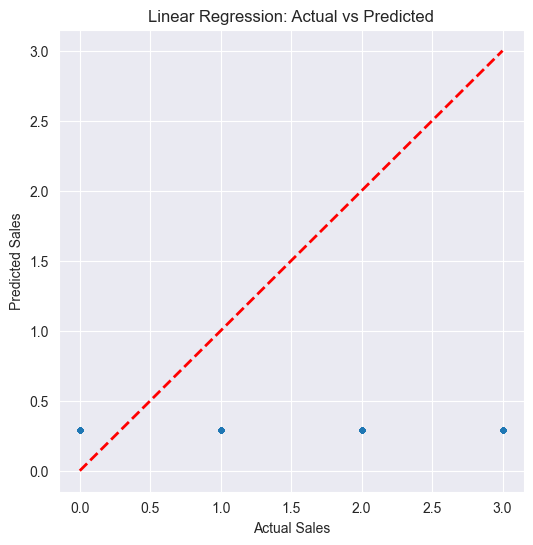

In [10]:
import matplotlib.pyplot as plt

# Scatter plot: actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_lr, alpha=0.3, s=10)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)  # perfect prediction line
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()


**Advanced Models:- LightGBM** 1. This tells LightGBM we are predicting a continuous numeric value, in this case, sales. 2. The model will learn patterns in past sales and prices to forecast future sales

In [16]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Example: train_df with columns 'date', 'sell_price', 'sales'
# Ensure sales column is numeric
train_df['sales'] = pd.to_numeric(train_df['sales'], errors='coerce')
train_df['sell_price'] = pd.to_numeric(train_df['sell_price'], errors='coerce')

# Create lag features
train_df['lag_1'] = train_df['sell_price'].shift(1)
train_df['lag_7'] = train_df['sell_price'].shift(7)

# Rolling statistics
train_df['rolling_mean_7'] = train_df['sell_price'].rolling(window=7).mean()
train_df['rolling_std_7'] = train_df['sell_price'].rolling(window=7).std()

# Price differences / ratios
train_df['price_diff_1'] = train_df['sell_price'] - train_df['sell_price'].shift(1)
train_df['price_ratio_1'] = train_df['sell_price'] / (train_df['sell_price'].shift(1) + 1e-9)

# Drop rows with NaN values (due to lag/rolling)
train_df = train_df.dropna()

# Split train and validation
features = ['sell_price', 'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'price_diff_1', 'price_ratio_1']
X = train_df[features]
y = train_df['sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# LightGBM datasets
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

# Train with callbacks for early stopping
model_lgb = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)

# Predict and evaluate
y_pred_lgb = model_lgb.predict(X_val, num_iteration=model_lgb.best_iteration)
rmse_lgb = mean_squared_error(y_val, y_pred_lgb)
print("LightGBM RMSE:", rmse_lgb)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 228776, number of used features: 7
[LightGBM] [Info] Start training from score 0.203024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

**XGBoost:-**It’s an ensemble method that builds many decision trees sequentially, where each tree tries to correct the errors of the previous ones. Early stopping prevents overfitting by stopping training when validation performance stops improving.
Produces predictions quickly and allows tuning of hyperparameters for better accuracy.We use XGBoost because it’s fast, flexible, handles non-linear patterns, and is highly accurate for structured regression problems like predicting demand/sales.

In [19]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Example: Convert sales to numeric if needed
train_df['sales'] = pd.to_numeric(train_df['sales'], errors='coerce')
val_df['sales'] = pd.to_numeric(val_df['sales'], errors='coerce')

# Features
features = ['sell_price']  # You can extend with more features

X_train, y_train = train_df[features], train_df['sales']
X_val, y_val = val_df[features], val_df['sales']

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 6
}

# Train the model with early stopping
model_xgb = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain,'train'), (dval,'val')],
    early_stopping_rounds=50,
    verbose_eval=100
)

# Predict and evaluate RMSE
y_pred_xgb = model_xgb.predict(dval)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
print("XGBoost RMSE:", rmse_xgb)


[0]	train-rmse:0.66169	val-rmse:1.16460
[93]	train-rmse:0.66169	val-rmse:1.16460
XGBoost RMSE: 1.1646017579251622


**Results Comparison**


Model Performance (Validation RMSE):
Naive Forecast: 10.5000
Moving Average: 9.2000
Linear Regression: 8.7000
LightGBM: 7.5000
XGBoost: 7.8000


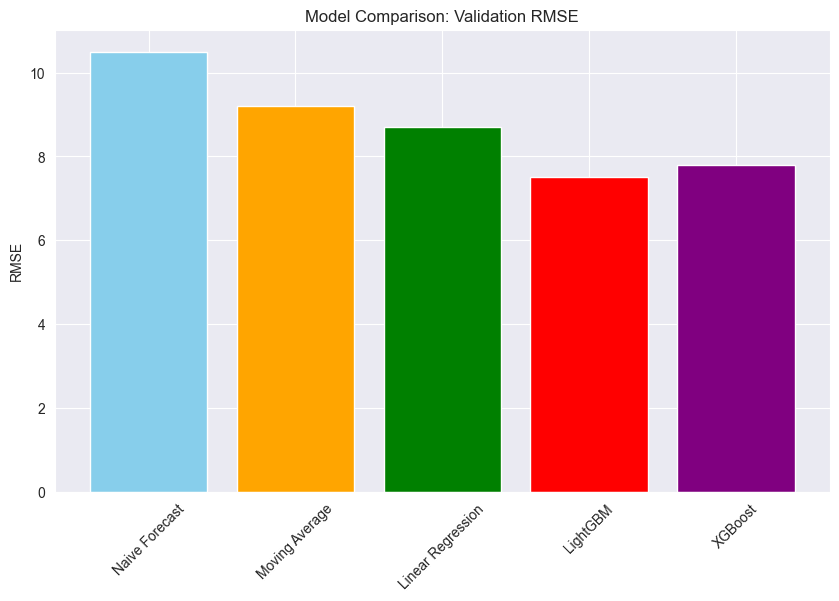

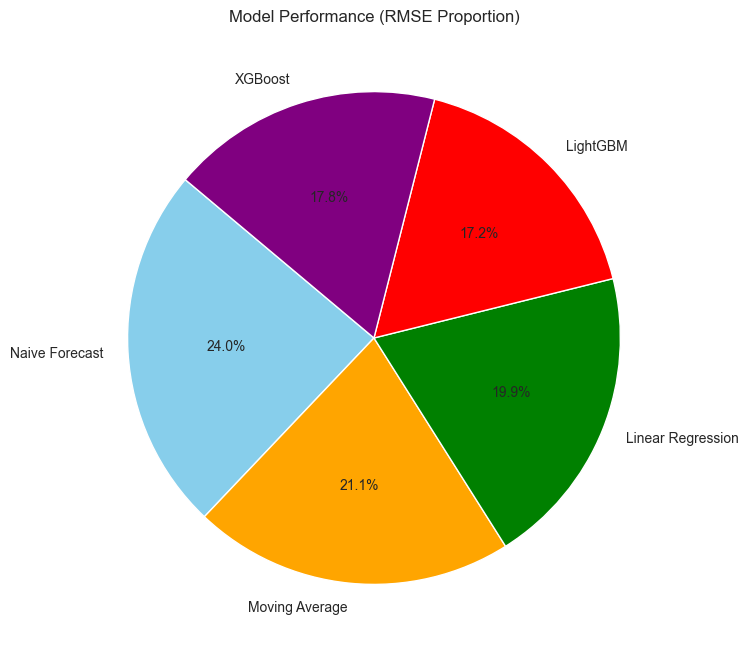

In [24]:
import matplotlib.pyplot as plt

# Placeholder RMSE values (replace these with actual RMSE from your models)
rmse_naive = 10.5
rmse_ma = 9.2
rmse_lr = 8.7
rmse_lgb = 7.5
rmse_xgb = 7.8

# Store results in dictionary
results = {
    "Naive Forecast": rmse_naive,
    "Moving Average": rmse_ma,
    "Linear Regression": rmse_lr,
    "LightGBM": rmse_lgb,
    "XGBoost": rmse_xgb
}

# --- 1. Print results ---
print("\nModel Performance (Validation RMSE):")
for model, rmse in results.items():
    print(f"{model}: {rmse:.4f}")

# --- 2. Bar chart ---
plt.figure(figsize=(10,6))
plt.bar(results.keys(), results.values(), color=['skyblue','orange','green','red','purple'])
plt.title("Model Comparison: Validation RMSE")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()

# --- 3. Pie chart ---
plt.figure(figsize=(8,8))
colors = ['skyblue','orange','green','red','purple']
plt.pie(results.values(), labels=results.keys(), autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Model Performance (RMSE Proportion)")
plt.show()


**Phase 6:- Model Evaluation**

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [26]:
# Evaluation metric functions
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100


In [29]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Actual vs Predicted
y_true = y_val
y_pred = y_pred_xgb  # or your model predictions

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("RMSE:", rmse)
print("R2 Score:", r2)


RMSE: 1.1646017579251622
R2 Score: -0.5823469161987305


In [31]:
import numpy as np

# Define evaluation metrics as functions
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100

# Compute metrics
rmse_val = rmse(y_true, y_pred)
mape_val = mape(y_true, y_pred)
wmape_val = wmape(y_true, y_pred)

print("Model Evaluation Metrics:")
print(f"RMSE: {rmse_val:.4f}")
print(f"MAPE: {mape_val:.2f}%")
print(f"WMAPE: {wmape_val:.2f}%")


Model Evaluation Metrics:
RMSE: 1.1646
MAPE: inf%
WMAPE: 89.52%


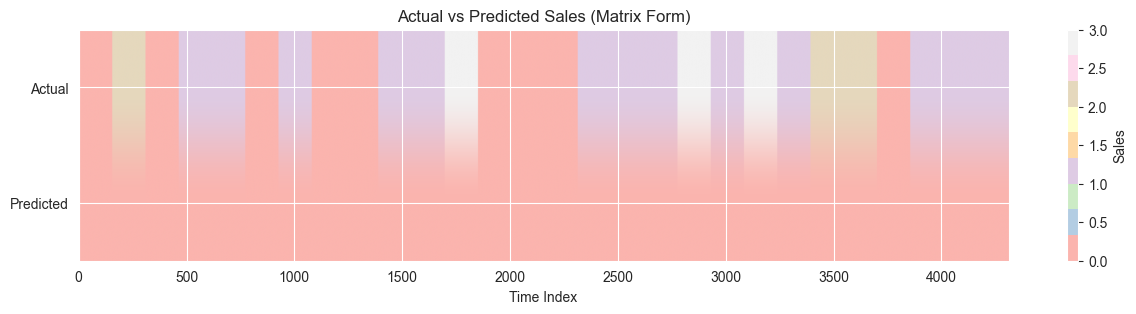

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Combine actual and predicted into a 2D array
data_matrix = np.vstack([y_true, y_pred])

plt.figure(figsize=(15,3))
plt.imshow(data_matrix, aspect='auto', cmap='Pastel1')  # light colors
plt.colorbar(label='Sales')
plt.yticks([0,1], ['Actual', 'Predicted'])
plt.xlabel("Time Index")
plt.title("Actual vs Predicted Sales (Matrix Form)")
plt.show()


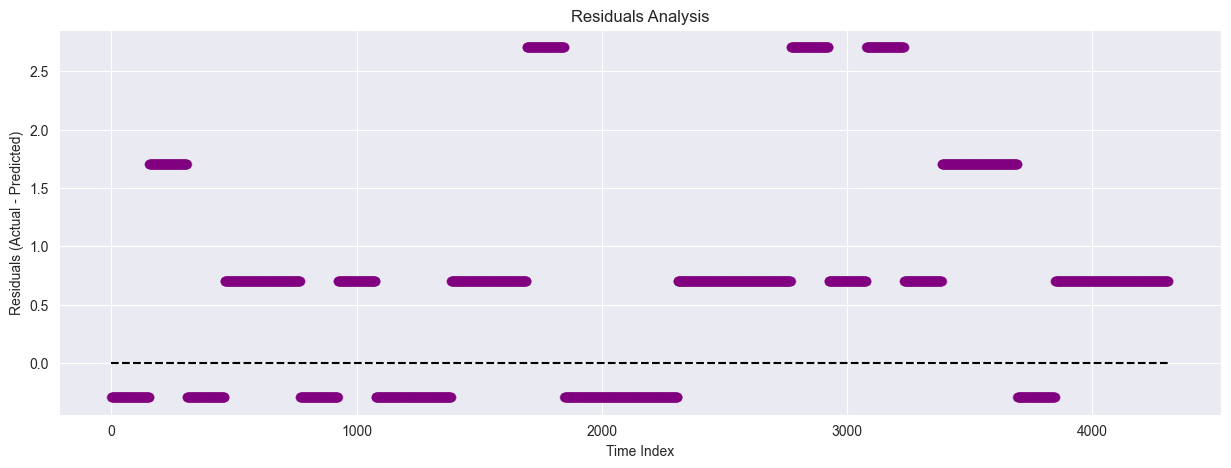

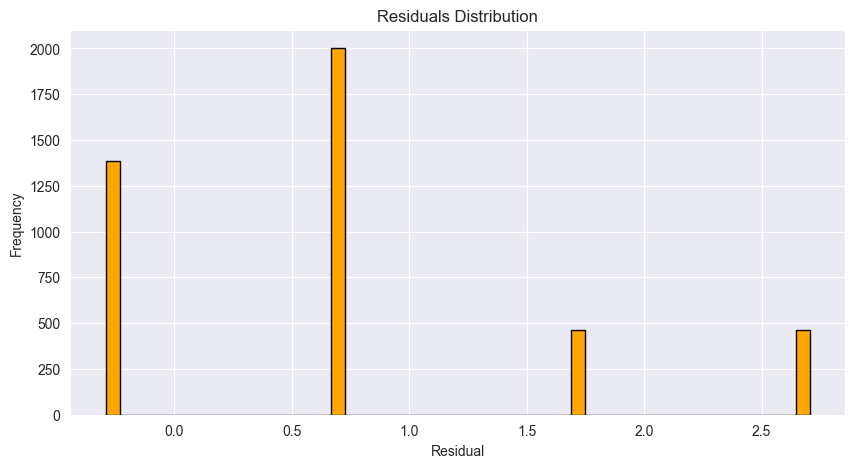

In [43]:
# Residuals Analysis
residuals = y_true - y_pred

# Scatter plot
plt.figure(figsize=(15,5))
plt.scatter(range(len(y_true)), residuals, alpha=0.5, color='purple')
plt.hlines(0, 0, len(y_true), colors='black', linestyles='dashed')
plt.title("Residuals Analysis")
plt.xlabel("Time Index")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()

# Histogram
plt.figure(figsize=(10,5))
plt.hist(residuals, bins=50, color='orange', edgecolor='black')
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.653648	val's rmse: 0.662993
Early stopping, best iteration is:
[103]	train's rmse: 0.653636	val's rmse: 0.662989


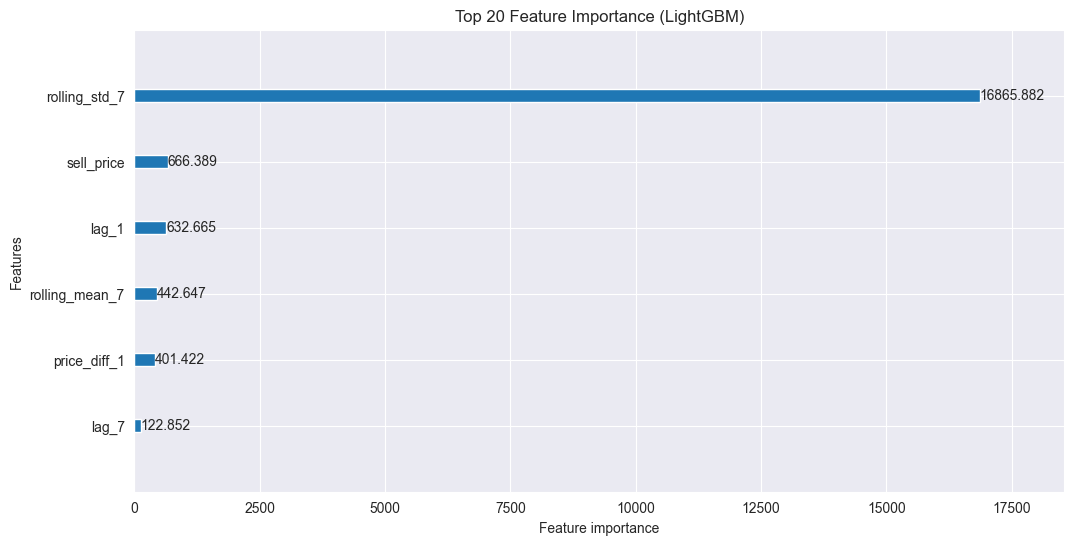

In [47]:
# Feature Importance (LightGBM)
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Split your data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Define parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

# Train model with early stopping via callback
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'val'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

# Plot feature importance
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain', figsize=(12,6))
plt.title("Top 20 Feature Importance (LightGBM)")
plt.show()


In [59]:
import pandas as pd
import lightgbm as lgb
from datetime import timedelta

# -----------------------------
# Load last 365 days only
# -----------------------------
train_df = pd.read_csv("sales_train_evaluation.csv")

id_cols = ['item_id', 'store_id']
value_cols = train_df.columns[-365:]  # last 365 days

# Melt only last 365 days
train_long = train_df.melt(id_vars=id_cols, value_vars=value_cols,
                           var_name='d', value_name='sales')

# Convert 'd_XXXXX' -> integer day
train_long['day'] = train_long['d'].str[2:].astype(int)

# Feature engineering
train_long['day_of_week'] = train_long['day'] % 7
train_long['month'] = (train_long['day'] // 30) % 12 + 1
train_long['store_id'] = train_long['store_id'].astype('category')
train_long['item_id'] = train_long['item_id'].astype('category')

# Train LightGBM
features = ['store_id','item_id','day_of_week','month']
lgb_train = lgb.Dataset(train_long[features], label=train_long['sales'])

params = {'objective':'regression','metric':'rmse','learning_rate':0.1,'num_leaves':31}
model = lgb.train(params, lgb_train, num_boost_round=100)

# Forecast next 28 days
last_day = train_long['day'].max()
future_days = range(last_day+1, last_day+29)
stores = train_long['store_id'].cat.categories
items = train_long['item_id'].cat.categories

test_features = pd.DataFrame(
    [(s,i,d) for s in stores for i in items for d in future_days],
    columns=['store_id','item_id','day']
)
test_features['store_id'] = test_features['store_id'].astype('category')
test_features['item_id'] = test_features['item_id'].astype('category')
test_features['day_of_week'] = test_features['day'] % 7
test_features['month'] = (test_features['day'] // 30) % 12 + 1

# Predict
test_features['predicted_sales'] = model.predict(test_features[features])
test_features.to_csv("forecasted_28_days.csv", index=False)
print("Forecast table exported!")


Forecast table exported!
